In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import imageio
import numpy as np
import cv2 as cv2
from skimage.color import rgb2gray,gray2rgb
import pickle,bz2
import seaborn as sns
from keras.preprocessing.image  import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


## Entrenando con ImageDataGenerator y con las imagenes normalizadas.
#### En el notebook anterior se afronto el problema cargando la totalidad del dataset en el entorno de jupyter, por lo que  el uso de recursos era mayor y nos impedia realizar un entrenamiento con un batch grande debido a que se llenaba la memoria lo que detenia el entrenamiento.
#### Para solucionarlo se implemento entonces la carga de los datos por medio de ImageDataGenerator de Keras, esto evita cargar  las imagenes en su totalidad y solo se cargan las imagenes usadas por cada batch en el entrenamiento.

#### En esta ocasion se entreno con un batch de 15 y 1 epoca, para comparar los resultados.

In [2]:
train_datagen=ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    directory="chest_xray/train",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=15
)


Found 5216 images belonging to 2 classes.


In [3]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory="chest_xray/test",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=15
)

Found 624 images belonging to 2 classes.


### Las imagenes de validacion se cargan puesto que solo son 16

In [4]:
val=[]
#arr = np.zeros((5216, 224, 224, 1))
i=0

for filename in glob.glob('chest_xray/val/PNEUMONIA/*.jpeg'): 
    im=imageio.imread(filename)
    im=cv2.resize(im,(224,224))
    #im=cv2.addWeighted( im, 1.2, im, 0, 1)
    im=gray2rgb(im)
    val.append((im,1))
for filename in glob.glob('chest_xray/val/NORMAL/*.jpeg'): 
    im=imageio.imread(filename)
    im=cv2.resize(im,(224,224))
    #im=cv2.addWeighted( im, 1.2, im, 0, 1)
    im=gray2rgb(im)
    val.append((im,0))



In [5]:

VAL=pd.DataFrame(val,columns=['rX','label'],index= None)
VAL=VAL.sample(frac=1) 

In [6]:

x_val=np.stack(VAL['rX'],axis=0)*1
y_val=np.stack(VAL['label'],axis=0)*1

In [7]:

y_val_oh=pd.get_dummies(y_val)

### Visualizacion de las imagenes y sus caracteristicas segun la clase.

La neumonía es una enfermedad del sistema respiratorio que consiste en la inflamación de los espacios alveolares de los pulmones que puede afectar a un lóbulo pulmonar completo , a un segmento de lóbulo, a los alvéolos próximos a los bronquios  o al tejido intersticial. La neumonía hace que el tejido que forma los pulmones se vea enrojecido, hinchado, ademas produce liquido en el espacio pulmonar por lo que su deteccion por tecnicas de rayos x es posible, normalmente el especialista visualiza manchas de alta intensidad en los pulmones.

*Tomado de eMedicine*

/home/gabriel24/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(1, 15 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


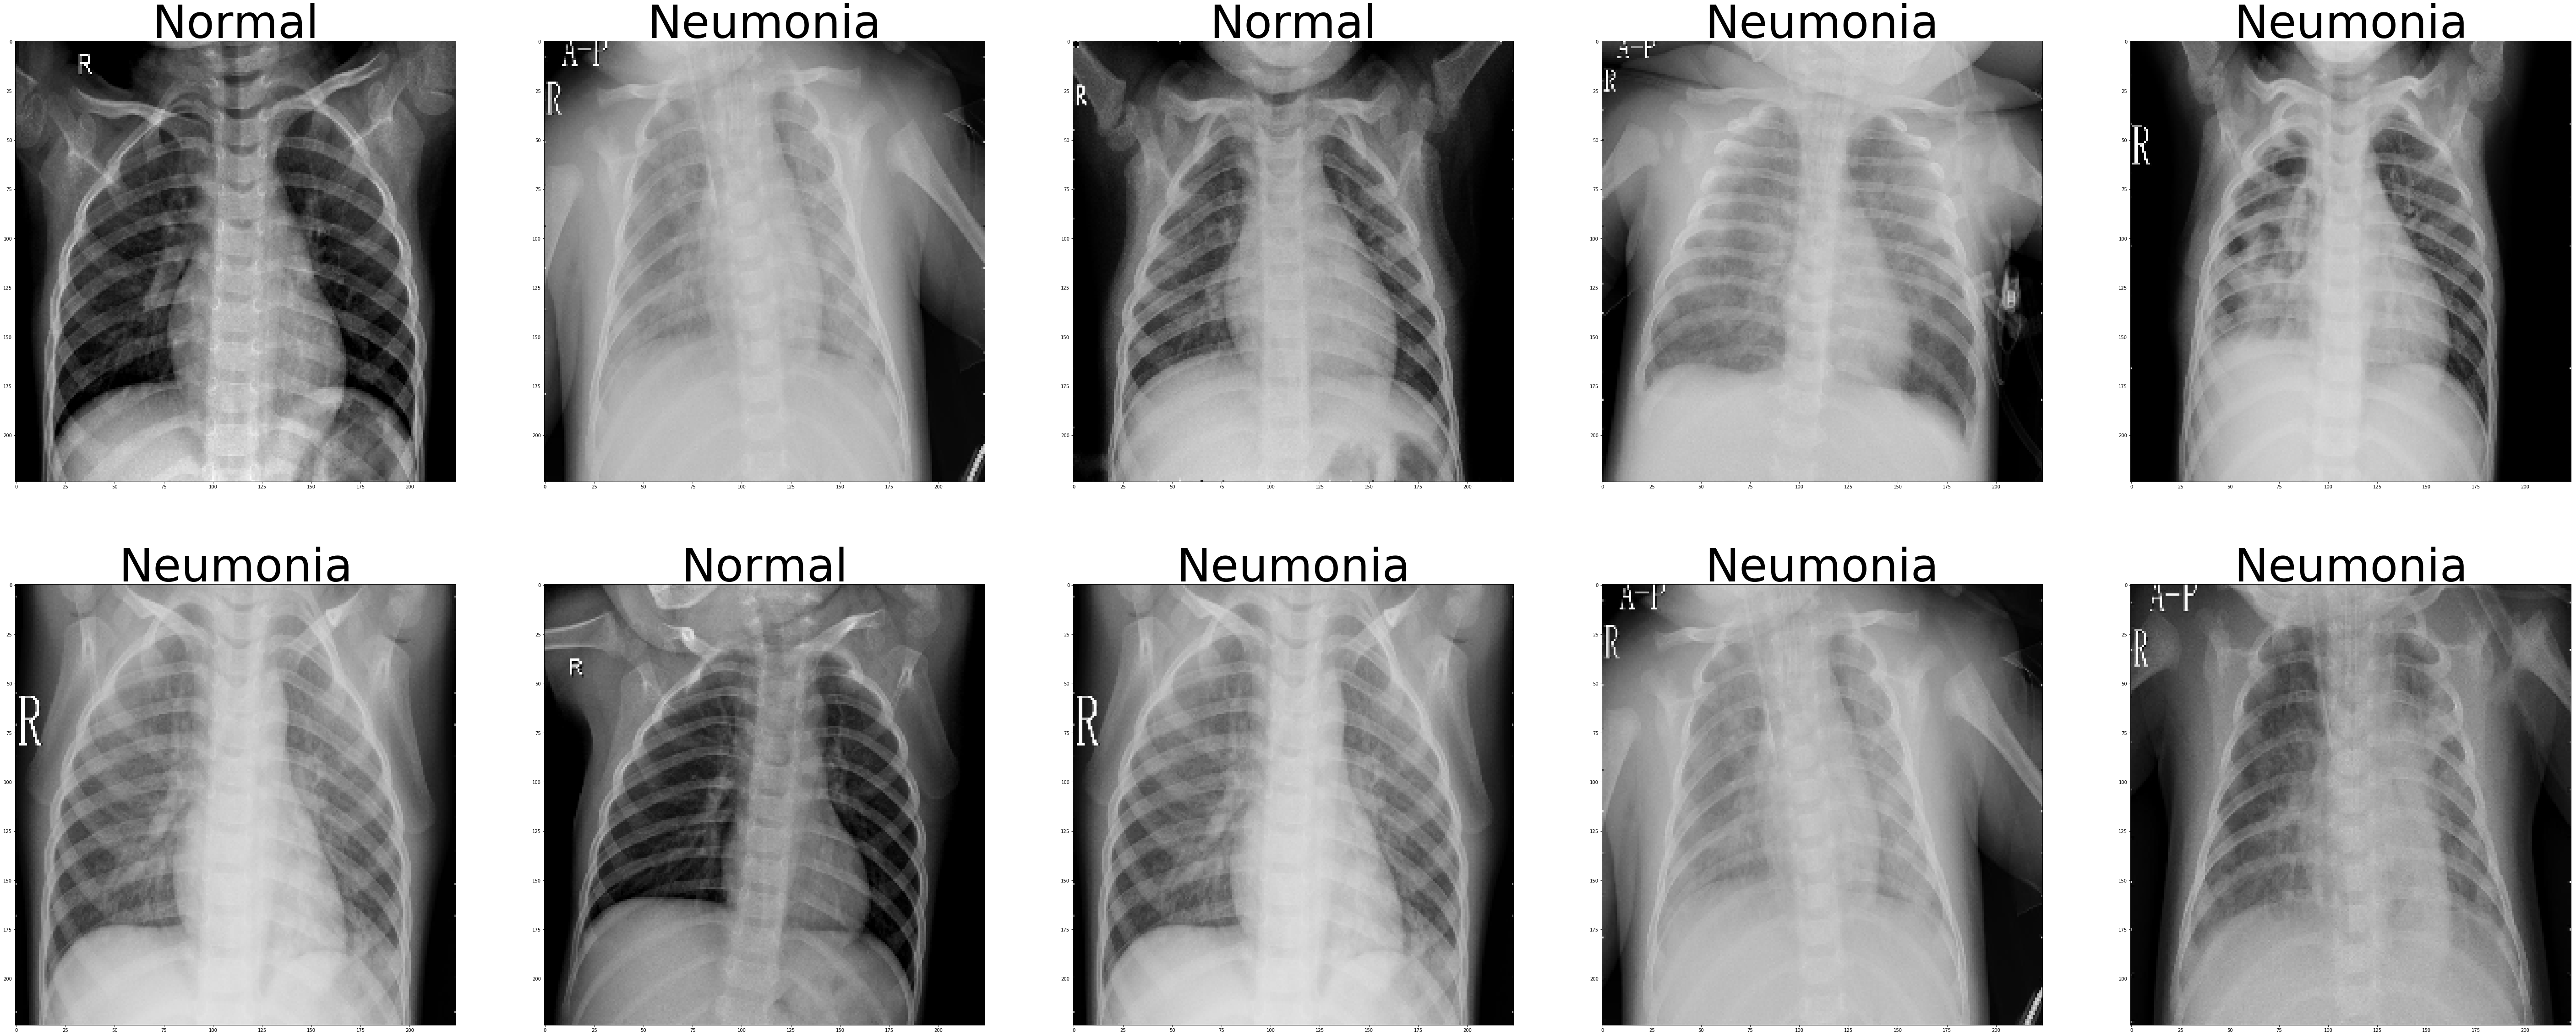

In [10]:
plt.figure(figsize=(100,40))
for i in range(1,11):
    b=np.random.random_integers(15)
    a=VAL['rX'][b]
    #a=cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
    c=VAL['label'][b]    
    plt.subplot(2,5,i)    
    plt.imshow(a,cmap="gray")
    if c==1:plt.title('Neumonia',fontdict={'fontsize':100}) #get the title property handler  
    else:plt.title('Normal',fontdict={'fontsize':100}) #get the title property handler  
    

A partir de un estudio acerca de varios modelos desarrollados para tareas tales como la clasificación de imágenes, se encontró que uno de los modelos que alcanzan una buena exactitud es el VGG con aproximadamente 71%, el cual está por encima de arquitecturas como Alexnet y googlenet y en temas de costo computacional no es tan compleja como la arquitectura InceptionV4 que alcanza un 80%. 

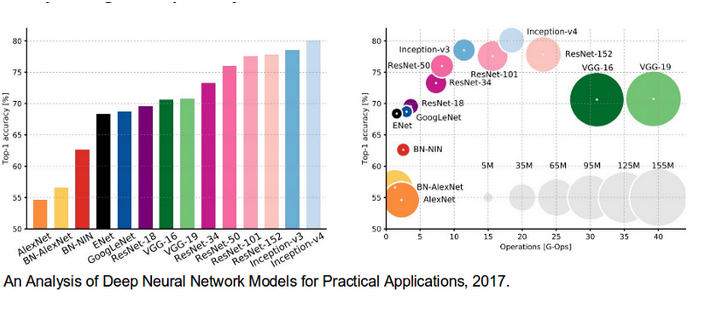

#### De acuerdo a lo anterior se propone usar transferlearning apartir de la red convolucional  VGG, por lo tanto se crea la arquitectura para posteriormente cargar los pesos.
Red: https://www.kaggle.com/keras/vgg16 , https://arxiv.org/pdf/1409.1556.pdf

In [8]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import h5py

In [9]:
def get_transfer_model():
    input_img = Input(shape=(224,224,3), name='input')
    layer = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    layer = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(layer)
    layer = MaxPooling2D((2,2), name='pool1')(layer)       
    layer = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(layer)
    layer = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(layer)
    layer = MaxPooling2D((2,2), name='pool2')(layer)    
    layer = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(layer)
    layer = BatchNormalization(name='bn1')(layer)
    layer = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(layer)
    layer = BatchNormalization(name='bn2')(layer)
    layer = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(layer)
    layer = MaxPooling2D((2,2), name='pool3')(layer)    
    layer = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(layer)
    layer = BatchNormalization(name='bn3')(layer)
    layer = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(layer)
    layer = BatchNormalization(name='bn4')(layer)
    layer = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(layer)
    layer = MaxPooling2D((2,2), name='pool4')(layer)    
    layer = Flatten(name='flatten')(layer)
    layer = Dense(1024, activation='relu', name='fc1')(layer)
    layer = Dropout(0.7, name='dropout1')(layer)
    layer = Dense(512, activation='relu', name='fc2')(layer)
    layer = Dropout(0.5, name='dropout2')(layer)
    layer = Dense(2, activation='softmax', name='fc3')(layer)    
    model = Model(inputs=input_img, outputs=layer)
    return model

In [10]:
model =  get_transfer_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableCon

In [14]:
# Cargando los pesos de la red VGG 
weights = h5py.File('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Transfiriendo los pesos a nuestra arquitectura

w,b = weights['block1_conv1']['block1_conv1_W_1:0'], weights['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = weights['block1_conv2']['block1_conv2_W_1:0'], weights['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = weights['block2_conv1']['block2_conv1_W_1:0'], weights['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = weights['block2_conv2']['block2_conv2_W_1:0'], weights['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

weights.close()
model.summary()    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [11]:
opt = Adam(lr=0.001, decay=1e-5)
es = EarlyStopping(patience=5)
check = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [12]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=test_generator.n//test_generator.batch_size

#### Al llamar el FIT, asignamos el parametro class_weigths que nos ayuda a lidiar con el desbalance de las clases.

In [13]:
h=model.fit_generator(generator=train_generator, epochs=1, verbose=1, callbacks=[es, check],  validation_data=test_generator, class_weight={0:1.0, 1:0.4},shuffle=True,steps_per_epoch=STEP_SIZE_TRAIN,validation_steps=STEP_SIZE_VALID)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
347/347 [==============================] - 1986s 6s/step - loss: 0.3839 - acc: 0.7126 - val_loss: 0.6874 - val_acc: 0.6276


# 71.26 % en entrenamiento y 62% en el set de test, en este caso notamos que la normalizacion no es conveniente en este caso en comparacion con los entrenamientos que se realizaron con imagenes sin normalizar.